In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import hdbscan
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.metrics import silhouette_score, davies_bouldin_score
from hdbscan import HDBSCAN

In [2]:
df = pd.read_csv("sechi.csv")

In [3]:
numeric_cols = [
    'mean_secchi','median_secchi','sd_secchi','covar_secchi',
    'lake_area_ha','lake_perim_meters','meandepth','maxdepth',
    'pcturbancombined_hu12','pctagcombined_hu12',
    'pctpasturehay_hu12','pctrowcrop_hu12'
]

categorical_cols = ['glacial', 'lakeconnectivity','state_name']

# Numerik
X_num = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Kategorikal → one-hot encoding
X_cat = pd.get_dummies(df[categorical_cols], drop_first=True)

# Gabung
X_all = pd.concat([X_num, X_cat], axis=1)

In [4]:
# Imputasi + Scaling

imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X_all)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

C:\Users\User\miniforge3\Lib\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['lake_area_ha']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


In [5]:
# HDBSCAN
hdb = hdbscan.HDBSCAN(min_cluster_size=10, min_samples=2, metric='euclidean')
labels_hdb = hdb.fit_predict(X_scaled)


C:\Users\User\miniforge3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\miniforge3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


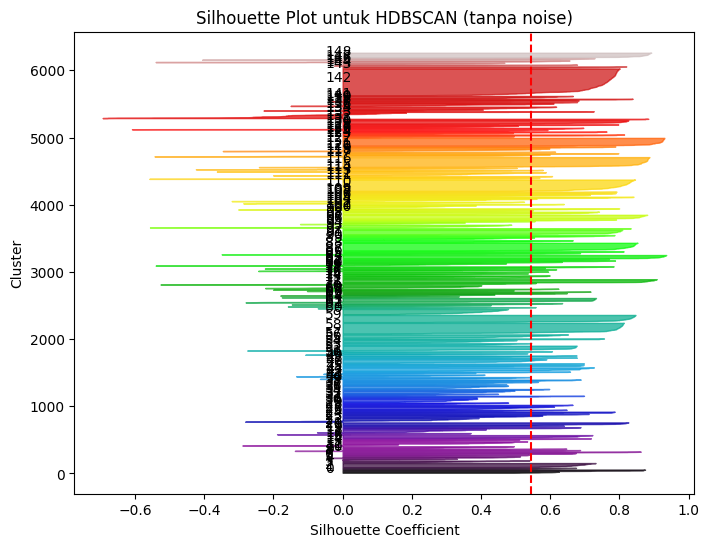

In [6]:
# Evaluasi cluster (Silhouette + DBI)
from sklearn.metrics import silhouette_samples
import matplotlib.cm as cm

# Buang noise (-1)
mask = labels_hdb != -1
X_valid = X_scaled[mask]
labels_valid = labels_hdb[mask]

if len(set(labels_valid)) > 1:  
    # Evaluasi silhouette score
    sample_silhouette_values = silhouette_samples(X_valid, labels_valid)

    # Plot Silhouette
    plt.figure(figsize=(8,6))
    y_lower = 10
    for i in np.unique(labels_valid):
        ith_cluster_silhouette_values = sample_silhouette_values[labels_valid == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / len(set(labels_valid)))
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10 

    plt.axvline(x=np.mean(sample_silhouette_values), color="red", linestyle="--")
    plt.xlabel("Silhouette Coefficient")
    plt.ylabel("Cluster")
    plt.title("Silhouette Plot untuk HDBSCAN (tanpa noise)")
    plt.show()

else:
    print("[HDBSCAN] Tidak bisa membuat silhouette plot: hanya 1 cluster atau semua noise.")


In [7]:
# Ringkasan cluster
n_clusters_hdb = len(set(labels_hdb)) - (1 if -1 in labels_hdb else 0)
print("Jumlah cluster HDBSCAN:", n_clusters_hdb)
print("Cluster unik:", np.unique(labels_hdb))

cluster_counts = pd.Series(labels_hdb).value_counts().sort_index()
print("\nJumlah anggota tiap cluster:")
print(cluster_counts)

Jumlah cluster HDBSCAN: 149
Cluster unik: [ -1   0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16
  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34
  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52
  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70
  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88
  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106
 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124
 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142
 143 144 145 146 147 148]

Jumlah anggota tiap cluster:
-1      1497
 0        15
 1        23
 2        14
 3        63
        ... 
 144      16
 145      18
 146      24
 147      26
 148      70
Name: count, Length: 150, dtype: int64


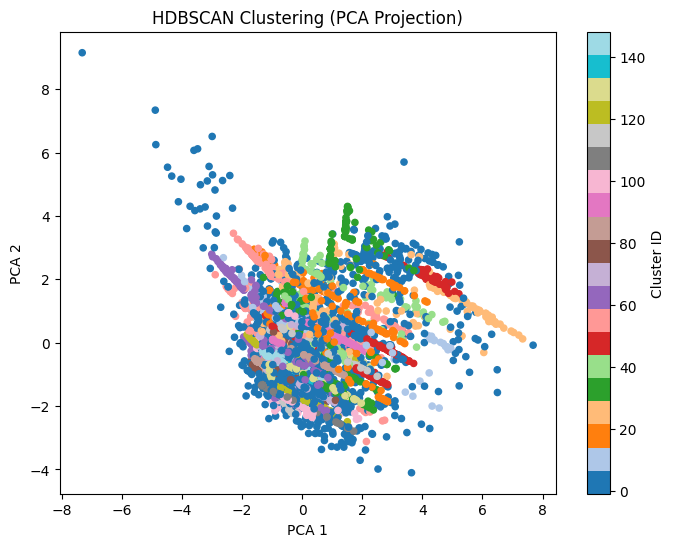

In [8]:
# PCA Projection
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels_hdb, cmap="tab20", s=20)
plt.title("HDBSCAN Clustering (PCA Projection)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(label="Cluster ID")
plt.show()

In [9]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=15, min_samples=10, prediction_data=True)
labels = clusterer.fit_predict(X_scaled)

C:\Users\User\miniforge3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\miniforge3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [10]:
valid_labels_mask = labels >= 0
X_valid = X_scaled[valid_labels_mask]
labels_valid = labels[valid_labels_mask]

In [11]:
n_clusters_valid = len(np.unique(labels_valid))
n_samples_valid = len(X_valid)

if n_clusters_valid > 1 and n_samples_valid > n_clusters_valid:
    silhouette = silhouette_score(X_valid, labels_valid)
    dbi = davies_bouldin_score(X_valid, labels_valid)

    print(f"Jumlah Cluster Teridentifikasi (tanpa noise): {n_clusters_valid}")
    print(f"Jumlah Titik Data yang Terklaster: {n_samples_valid}")
    print(f"Silhouette Score: {silhouette:.4f}")
    print(f"Davies-Bouldin Score: {dbi:.4f}")
else:
    print(f"Jumlah Cluster Teridentifikasi (tanpa noise): {n_clusters_valid}")
    print(f"Jumlah Titik Data yang Terklaster: {n_samples_valid}")

Jumlah Cluster Teridentifikasi (tanpa noise): 71
Jumlah Titik Data yang Terklaster: 4450
Silhouette Score: 0.5449
Davies-Bouldin Score: 0.7504


ANALISA Mengidentifikasi Klaster Danau Berisiko Berdasarkan Profil Tekanan Antropogenik (Faktor Lingkungan)

In [12]:
# fitur numerik utama untuk clustering
required_num = ["mean_secchi", "median_secchi", "pctrowcrop_hu12", "pcturbancombined_hu12"]
cand_connectivity = [
    "lakeconnectivity_Isolated",
    "lakeconnectivity_DR_Stream",
    "lakeconnectivity_Connected",
    "lakeconnectivity_Disconnected"
]

required_cat = [c for c in cand_connectivity if c in df.columns]

missing = [c for c in required_num if c not in df.columns]
if missing:
    raise ValueError(f"Kolom berikut tidak ditemukan dalam dataset: {missing}")

In [13]:
import re
import numpy as np
import pandas as pd

def coerce_mixed_number(x):
    if pd.isna(x):
        return np.nan
    s = str(x).strip()

    s = s.replace(',', '.')

    s = re.sub(r'[^0-9.\-]', '', s)

    if s.count('.') > 1:
        first = s.find('.')
        s = s[:first+1] + s[first+1:].replace('.', '')

    try:
        return float(s)
    except Exception:
        return np.nan

df[required_num] = df[required_num].applymap(coerce_mixed_number)

print("NA per kolom setelah konversi:")
print(df[required_num].isna().sum())

for c in required_num:
    med = df[c].median(skipna=True)
    df[c] = df[c].fillna(med)


NA per kolom setelah konversi:
mean_secchi                0
median_secchi              0
pctrowcrop_hu12          135
pcturbancombined_hu12    135
dtype: int64


C:\Users\User\AppData\Local\Temp\ipykernel_28208\477565069.py:23: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[required_num] = df[required_num].applymap(coerce_mixed_number)


In [14]:
X_num = df[required_num].copy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_num)

clusterer = HDBSCAN(min_cluster_size=5)
labels_hdb = clusterer.fit_predict(X_scaled)


df_risk = df.copy()
df_risk["cluster"] = labels_hdb
df_risk = df_risk[df_risk["cluster"] != -1].copy()  

C:\Users\User\miniforge3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\miniforge3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [15]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = MinMaxScaler()

secchi_scaled = scaler.fit_transform(df_risk[["mean_secchi"]]).ravel()
rowcrop_scaled = scaler.fit_transform(df_risk[["pctrowcrop_hu12"]]).ravel()
urban_scaled   = scaler.fit_transform(df_risk[["pcturbancombined_hu12"]]).ravel()

risk_secchi = 1 - secchi_scaled   
risk_agri   = rowcrop_scaled      
risk_urban  = urban_scaled        
risk_conn   = df_risk.get("lakeconnectivity_Isolated", pd.Series(0, index=df_risk.index)).astype(float)


w_secchi, w_agri, w_urban, w_conn = 0.40, 0.30, 0.20, 0.10


df_risk["risk_score"] = (
    w_secchi * risk_secchi +
    w_agri   * risk_agri   +
    w_urban  * risk_urban  +
    w_conn   * risk_conn
)


df_risk["risk_level"] = pd.qcut(df_risk["risk_score"], q=3, labels=["Low", "Moderate", "High"])


In [16]:
agg_dict = {
    "mean_secchi": ["mean", "median"],
    "pctrowcrop_hu12": "mean",
    "pcturbancombined_hu12": "mean",
    "risk_score": "mean"
}
for c in required_cat:
    agg_dict[c] = "mean"

cluster_profile = df_risk.groupby("cluster").agg(agg_dict).round(3)
cluster_profile.columns = ["_".join(col) if isinstance(col, tuple) else col for col in cluster_profile.columns]
cluster_profile = cluster_profile.sort_values(by="risk_score_mean", ascending=False).reset_index()

print("Profil Klaster dengan Risiko Tertinggi:")
display(cluster_profile.head(10))

Profil Klaster dengan Risiko Tertinggi:


,cluster,mean_secchi_mean,mean_secchi_median,pctrowcrop_hu12_mean,pcturbancombined_hu12_mean,risk_score_mean
0,2,2.375,2.700,872.889,770.402,0.830
1,76,3.952,3.600,978.000,2.994,0.695
2,3,2.048,1.680,381.000,802.401,0.689
3,77,2.364,2.175,945.750,6.235,0.686
4,79,3.689,3.607,894.012,4.431,0.670
5,83,2.760,2.740,850.861,3.896,0.657
6,87,1.386,1.370,825.000,2.263,0.649
7,86,1.032,1.010,804.280,6.804,0.644
8,94,0.834,0.805,766.668,5.389,0.633
9,95,1.496,1.050,749.421,6.479,0.627


C:\Users\User\AppData\Local\Temp\ipykernel_28208\3400266013.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=cluster_profile.head(10),


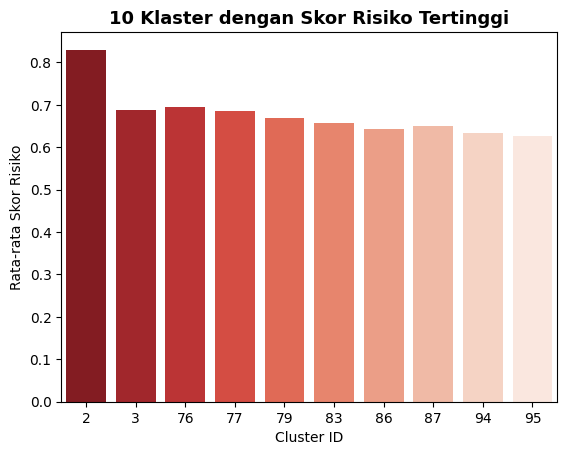

In [17]:
sns.barplot(data=cluster_profile.head(10),
            x="cluster", y="risk_score_mean", palette="Reds_r")
plt.title("10 Klaster dengan Skor Risiko Tertinggi", fontsize=13, fontweight='bold')
plt.xlabel("Cluster ID")
plt.ylabel("Rata-rata Skor Risiko")
plt.show()

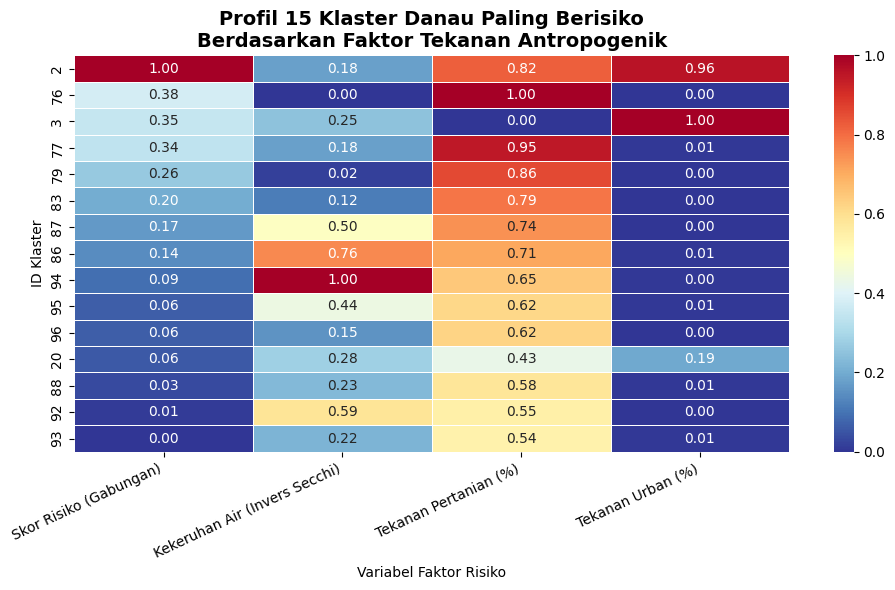

In [18]:
top_risk_clusters = cluster_profile.nlargest(15, "risk_score_mean")
top_risk_clusters["mean_secchi_inv"] = 1 / (top_risk_clusters["mean_secchi_mean"] + 1e-6)
scaler = MinMaxScaler()
cols_for_heat = ["risk_score_mean", "mean_secchi_inv", "pctrowcrop_hu12_mean", "pcturbancombined_hu12_mean"]

heat_df_scaled = pd.DataFrame(
    scaler.fit_transform(top_risk_clusters[cols_for_heat]),
    index=top_risk_clusters["cluster"],
    columns=["Skor Risiko (Gabungan)", "Kekeruhan Air (Invers Secchi)", "Tekanan Pertanian (%)", "Tekanan Urban (%)"]
)

plt.figure(figsize=(10, 6))
sns.heatmap(heat_df_scaled, cmap="RdYlBu_r", annot=True, fmt=".2f", linewidths=0.5)
plt.title("Profil 15 Klaster Danau Paling Berisiko\nBerdasarkan Faktor Tekanan Antropogenik",
          fontsize=14, fontweight="bold")
plt.xlabel("Variabel Faktor Risiko")
plt.ylabel("ID Klaster")
plt.xticks(rotation=25, ha="right")
plt.tight_layout()
plt.show()

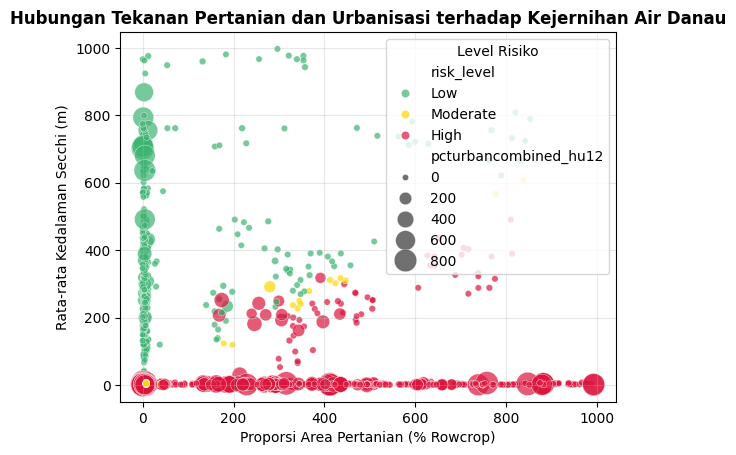

In [19]:
sns.scatterplot(
    data=df_risk,
    x="pctrowcrop_hu12", y="mean_secchi",
    hue="risk_level", size="pcturbancombined_hu12",
    sizes=(20, 300),
    palette={"Low": "#3CB371", "Moderate": "#FFD700", "High": "#DC143C"},
    alpha=0.7
)
plt.title("Hubungan Tekanan Pertanian dan Urbanisasi terhadap Kejernihan Air Danau", fontsize=12, fontweight='bold')
plt.xlabel("Proporsi Area Pertanian (% Rowcrop)")
plt.ylabel("Rata-rata Kedalaman Secchi (m)")
plt.legend(title="Level Risiko", loc="upper right", frameon=True)
plt.grid(alpha=0.3)
plt.show()

In [20]:
state_summary = (
    df_risk.groupby("state_name")
    .agg({
        "risk_score": ["mean", "max"],
        "mean_secchi": "mean",
        "pctrowcrop_hu12": "mean",
        "pcturbancombined_hu12": "mean"
    })
    .round(3)
)
state_summary.columns = ["_".join(col) for col in state_summary.columns]
state_summary = state_summary.sort_values("risk_score_mean", ascending=False)


C:\Users\User\AppData\Local\Temp\ipykernel_28208\2231139423.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


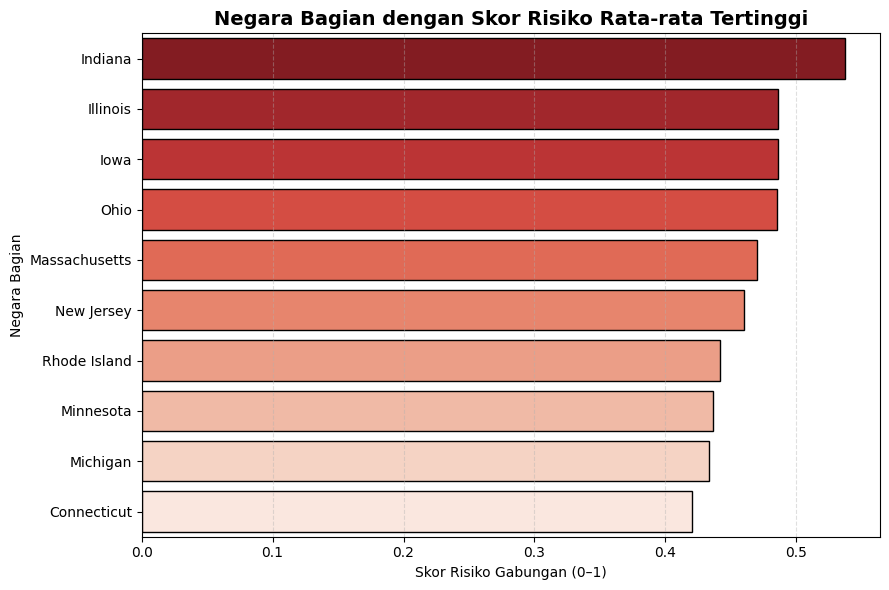

In [21]:
plt.figure(figsize=(9, 6))
sns.barplot(
    data=state_summary.head(10).reset_index(),
    y="state_name", x="risk_score_mean",
    palette="Reds_r", edgecolor="black"
)
plt.title("Negara Bagian dengan Skor Risiko Rata-rata Tertinggi", fontsize=14, fontweight="bold")
plt.xlabel("Skor Risiko Gabungan (0–1)")
plt.ylabel("Negara Bagian")
plt.grid(axis="x", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()